# Deep Matrix Factorisation

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

## Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [7]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [8]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(np.int64(1), np.int64(5))

In [9]:
train, test = user_split(DATA, "timestamp", "user_id", [0.9, 0.1])

In [10]:
train.shape, test.shape

((90009, 7), (9991, 7))

## Deep Matrix Factorization

In [11]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils import model_to_dot
from reco import vis

In [12]:
def Deep_MF(n_users, n_items, n_factors, min_rating=1, max_rating=5):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), 
                          embeddings_initializer='glorot_normal',
                          name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), 
                        embeddings_initializer='glorot_normal',
                          name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Concatenate user and item vectors
    Concat = Concatenate(name='Concat')([item_vec, user_vec])
    ConcatDrop = Dropout(0.5)(Concat)
    
    # Use Dense to learn non-linear dense representation
    Dense_1 = Dense(10, kernel_initializer='glorot_normal', name="Dense1")(ConcatDrop)
    Dense_1_Drop = Dropout(0.5)(Dense_1)
    Dense_2 = Dense(1, kernel_initializer='glorot_normal', name="Dense2")(Dense_1_Drop)

    # Add bias terms
    AddBias = Add(name="AddBias")([Dense_2, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    
    return model

In [13]:
n_factors = 50
model = Deep_MF(n_users, n_items, n_factors)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ User (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemEmbedding       │ (None, 1, 50)     │     84,100 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserEmbedding       │ (None, 1, 50)     │     47,150 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemE        │ (None, 50)        │          0 │ ItemEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserE        │ (None, 50)        │          0 │ UserEmbedding[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concat              │ (None, 100)       │          0 │ FlattenItemE[0][… │
│ (Concatenate)       │                   │            │ FlattenUserE[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100)       │          0 │ Concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense1 (Dense)      │ (None, 10)        │      1,010 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10)        │          0 │ Dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ItemBias            │ (None, 1, 1)      │      1,682 │ Item[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UserBias            │ (None, 1, 1)      │        943 │ User[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense2 (Dense)      │ (None, 1)         │         11 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenItemBiasE    │ (None, 1)         │          0 │ ItemBias[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FlattenUserBiasE    │ (None, 1)         │          0 │ UserBias[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AddBias (Add)       │ (None, 1)         │          0 │ Dense2[0][0],     │
│                     │                   │            │ FlattenItemBiasE… │
│                     │                   │            │ FlattenUserBiasE… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ AddBias[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ activation[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 134,896 (526.94 KB)

 Trainable params: 134,896 (526.94 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from reco.utils import create_directory
create_directory("/model-img")

Directory already exists d:\Work\Development\recommendation_system/model-img


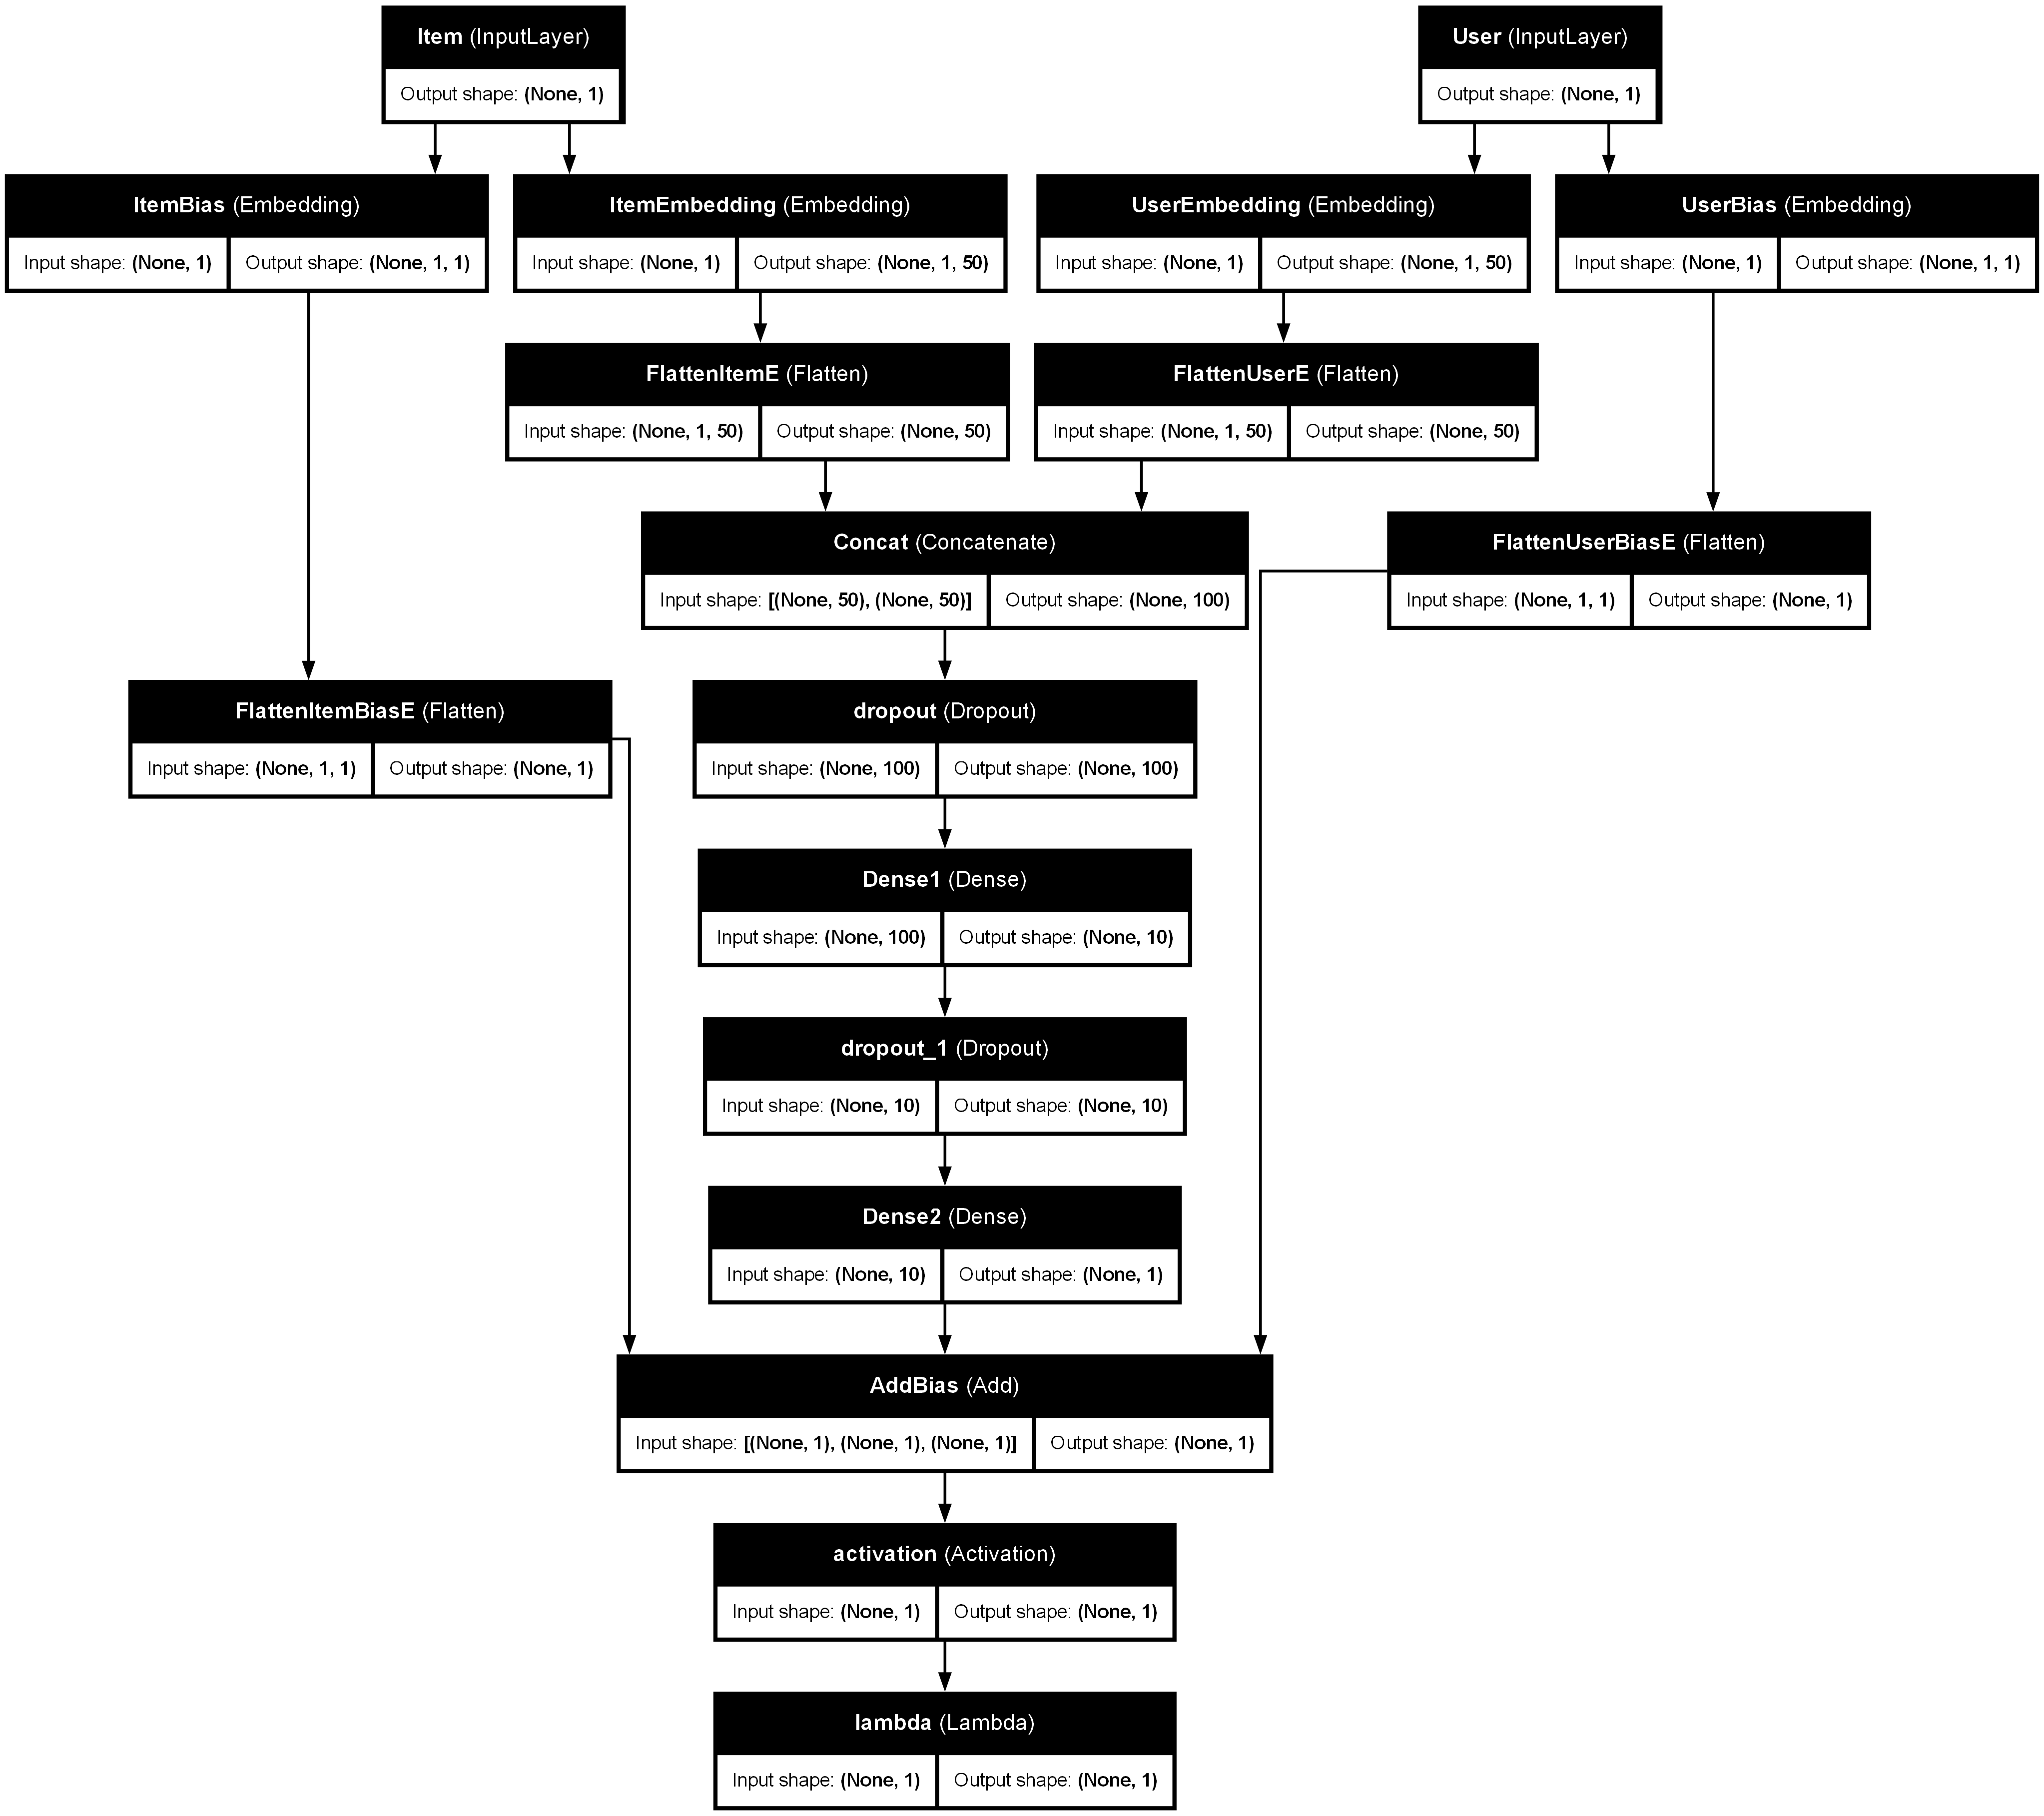

In [16]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/Deep-CF.png" )

## Train the model

In [17]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, 
                   validation_data= ([test.USER, test.ITEM], test.RATING))

Epoch 1/5


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1829 - val_loss: 0.9069
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9226 - val_loss: 0.8977
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8965 - val_loss: 0.8922
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8839 - val_loss: 0.8907
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8816 - val_loss: 0.8874
CPU times: total: 12.6 s
Wall time: 6.7 s


In [18]:
vis.metrics(output.history)

alt.FacetChart(...)

## Score the model

In [19]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.9122


0.8873896598815918

## Evaluate the model

In [20]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [21]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [22]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 27s 550us/step
CPU times: total: 52.9 s
Wall time: 45.6 s


In [23]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.043345
1,195,301,4.227501
2,195,376,2.452706
3,195,50,3.430257
4,195,345,3.784071


In [24]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 34s 683us/step
CPU times: total: 56 s
Wall time: 48.1 s


In [25]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.023321
Precision@K:	0.016543
Recall@K:	0.011988


## Get similar items

In [26]:
from reco.recommend import get_similar, show_similar

In [27]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: total: 156 ms
Wall time: 132 ms


In [31]:
item_similar_indices

array([[   0, 1592, 1546, 1541, 1447],
       [   1, 1351, 1644, 1624, 1639],
       [   2, 1577, 1155, 1618, 1416],
       ...,
       [1679, 1675, 1567, 1677, 1564],
       [1680, 1541, 1518, 1639, 1624],
       [1681, 1639, 1351, 1644, 1624]])

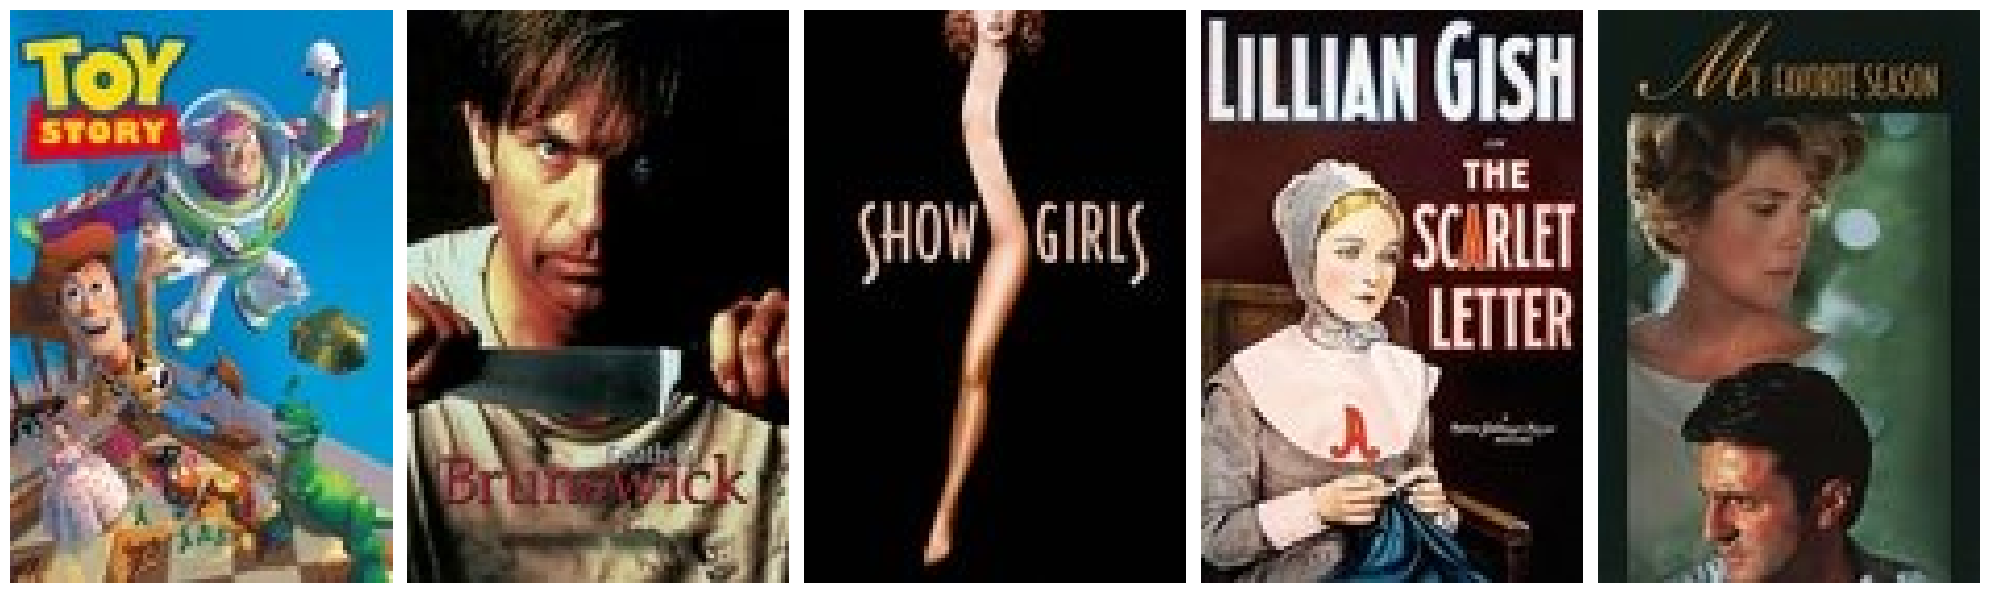

In [32]:
show_similar(0, item_similar_indices, item_encoder)